In [1]:
!datalad get ~/Desktop/studyforrest-data-eyemovementlabels
!datalad install ~/Desktop/studyforrest-data-eyemovementlabels

In [2]:
import os

import pandas as pd
import numpy as np
import multimatch_gaze as mmg
from mlxtend.evaluate import permutation_test

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
#plt.style.use('seaborn-whitegrid')

**Housekeeping happens here.**

In [3]:
sub_test_list = ['%.2d' % i for i in range(1, 20)]
sub_train_list= ['%.2d' % i for i in range(21, 37)]
run_list = ['%.1d' % j for j in range(1, 9)]

In [4]:
print('fMRI-Subjects: ', sub_test_list)
print('in-lab-Subjects: ', sub_train_list)

fMRI-Subjects:  ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
in-lab-Subjects:  ['21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36']


In [5]:
screen_size = [1280, 720]

In [6]:
# delete missing subjects from combi dataset
sub_test_list.remove('07')
sub_test_list.remove('08')
sub_test_list.remove('11')
sub_test_list.remove('12')
sub_test_list.remove('13')

# delete missing subjects from in-lab dataset
sub_train_list.remove('21')

data_dir = os.path.expanduser('~') + '/Desktop/studyforrest-data-eyemovementlabels'
out_dir = data_dir + '/code/output'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

chunk_dir = out_dir + '/chunks'

if not os.path.exists(chunk_dir):
    os.makedirs(chunk_dir)
    
scene_trans_dir = out_dir + '/scene_trans'

if not os.path.exists(scene_trans_dir):
    os.makedirs(scene_trans_dir)
    
scene_rnd_dir = out_dir + '/scene_rnd'

if not os.path.exists(scene_rnd_dir):
    os.makedirs(scene_rnd_dir)

In [7]:
def load_eye_data(data_dir, sub, run):
    '''
    Load individual eye-gaze paths for each subject. Add one column to indicate subject-id
    and one to indicate to current run.
    '''
    sub_data = data_dir + f'/sub-{sub}/sub-{sub}_task-movie_run-{run}_events.tsv' 
    eye_data = pd.read_csv(sub_data, sep='\t')
    eye_data.insert(loc=0, column='subject', value=int(sub))
    eye_data.insert(loc=1, column='run', value=int(run))
    
    return eye_data

In [8]:
def split_data(in_data, start_onset, stop_onset, time_step):
    '''
    Take input data, divide data into equally long chunks based on start and stop onsets, 
    return array of chunks.
    '''
    chunk_list = []
    for chunk in range(1, len(in_data['onset'])):
        
        if not in_data[(in_data['onset'] < stop_onset) & (in_data['onset'] > start_onset)].empty:
            chunk_tmp = in_data[(in_data['onset'] < stop_onset) & (in_data['onset'] > start_onset)]
            chunk_tmp.insert(loc=2, column='chunk', value=int(chunk))
            chunk_list.append(chunk_tmp)
            start_onset += time_step
            stop_onset += time_step
        
        else:
            break
            
    return chunk_list

In [9]:
start_onset = 0
stop_onset = 12
time_step = 12

labeled_train_data_out = []

In [10]:
for sub in sub_train_list:
    for run in run_list: 
        '''
        Loop through all subjects and runs, combine the specified columns.
        '''
        tmp_data = load_eye_data(data_dir, sub, run)#[['subject', 'run',  'onset', 'duration', 
                                                     # 'label', 'start_x', 'start_y', 'end_x', 'end_y']]
        labeled_train_data_out.append(tmp_data)

# combine the data
labeled_train_data = pd.concat(labeled_train_data_out, ignore_index=True)

# chunk the data 
chunk_train_data = pd.concat(split_data(in_data=labeled_train_data, start_onset=start_onset, 
                                        stop_onset=stop_onset, time_step=time_step), ignore_index=True)

**Get some descriptives for communication:**
- Overview of one chunk
- List of unique eye movement labels
- Number of processable chunks per run

In [11]:
chunk_train_data[(chunk_train_data['subject'] == 22) & (chunk_train_data['chunk'] == 1)]

,subject,run,chunk,onset,duration,label,start_x,start_y,end_x,end_y,amp,peak_vel,med_vel,avg_vel
0,22,1,1,0.024,0.033,SACC,675.3,261.4,595.8,265.1,2.122,144.123,51.388,69.940
1,22,1,1,0.057,0.088,FIXA,596.2,265.2,593.5,264.8,0.075,17.770,4.603,6.067
2,22,1,1,0.145,0.114,PURS,593.3,264.9,590.1,265.6,0.089,8.388,3.823,3.997
3,22,1,1,0.259,0.191,FIXA,590.2,265.5,591.1,264.8,0.034,16.433,3.348,3.898
4,22,1,1,0.450,0.031,SACC,591.5,264.2,652.6,212.5,2.135,160.804,58.510,76.345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,22,8,1,11.670,0.162,PURS,940.7,217.2,939.4,209.5,0.208,13.371,4.176,4.501
691,22,8,1,11.832,0.016,SACC,939.5,209.0,933.8,181.7,0.745,72.501,51.991,47.909
692,22,8,1,11.848,0.013,LPSO,933.6,181.7,936.5,187.4,0.170,22.286,14.149,13.565
693,22,8,1,11.861,0.055,FIXA,936.5,187.5,936.7,184.6,0.076,6.777,3.609,3.760


In [12]:
eyegaze_features = pd.unique(chunk_train_data['label']) # categorical data: get different labels types
eyegaze_features

array(['SACC', 'FIXA', 'PURS', 'LPSO', 'HPSO', 'ISAC', 'ILPS', 'IHPS'],
      dtype=object)

In [13]:
for run in run_list:
    print(f'Number of chunks in run-{run}: ', 
          np.max(chunk_train_data[(chunk_train_data['run'] == int(run))]['chunk']))

Number of chunks in run-1:  76
Number of chunks in run-2:  74
Number of chunks in run-3:  74
Number of chunks in run-4:  82
Number of chunks in run-5:  78
Number of chunks in run-6:  74
Number of chunks in run-7:  91
Number of chunks in run-8:  57


**Potential Problem:** 
- Recentering from one scene to another may introduce a similarity bias
- check if that's true

**Procedure:** 
- Compare all the similarity of all eye movements 3 seconds after scene change vs. eye movement at a 10 x random different location within the following scene of the same length
- Bootstrap the data and compare

In [14]:
annotation = pd.read_csv('~/Desktop/studyforrest_project/ds000113/code/studyforrest-data-annotations/researchcut/locations.tsv',
                   sep='\t')
annotation

,onset,duration,major_location,setting,locale,int_or_ext,flow_of_time,time_of_day
0,0.00,17.00,Paramount,mountain logo,mountain logo,ext,0,day
1,17.00,151.08,Savannah,sky over Savannah,sky over Savannah,ext,++,day
2,168.08,104.12,Savannah,bench at bus stop,bench at bus stop,ext,0,day
3,272.20,14.12,Greenbow Alabama,doctor's office,doctor's office,int,-,day
4,286.32,14.24,Greenbow Alabama,doctor's office,doctor's office,int,0,day
...,...,...,...,...,...,...,...,...
864,7004.32,1.56,Gump property,access-road,at the mail boxes,ext,0,day
865,7005.88,2.12,Gump property,access-road,at the mail boxes,ext,0,day
866,7008.00,5.00,Gump property,access-road,at the mail boxes,ext,0,day
867,7013.00,9.00,Gump property,access-road,at the mail boxes,ext,0,day


**Multimatch gaze output order:** Array of 5 scanpath similarity measures. Vector (Shape), Direction (Angle), Length, Position, and Duration. 1 means absolute similarity, 0 means lowest similarity possible.

**Random scenes:** Pick a random timeslot within each scene to test if the scanpath is actually different from the transition

In [15]:
index = 0
sample_duration = 3#1.5

for start_scene in annotation['onset'][:10]:
    index += 1

    rnd_start = np.around(np.random.uniform(start_scene + sample_duration, annotation['onset'][index]), decimals=2)
    print('Trans: start', start_scene, '\t stop', start_scene + sample_duration)
    
    print('Rnd: start', rnd_start, '\t stop', rnd_start + sample_duration)
    
    for sub in sub_train_list:
        file_name_trans = scene_trans_dir + f'/scene-trans-{index}_sub-{sub}.tsv'
        scene_trans = chunk_train_data[(chunk_train_data['subject'] == int(sub)) &
                                       (chunk_train_data['onset'] > start_scene) & 
                                       (chunk_train_data['onset'] < start_scene + sample_duration)].drop(columns=['subject', 'run', 'chunk'])

        scene_trans.to_csv(file_name_trans, index=False, sep ='\t')
        scene_trans.insert(loc=3, column='scene_trans', value=index)
        
        file_name_rnd = scene_rnd_dir + f'/scene-rnd-{index}_sub-{sub}.tsv'
        scene_rnd = chunk_train_data[(chunk_train_data['subject'] == int(sub)) &
                                       (chunk_train_data['onset'] > rnd_start) & 
                                       (chunk_train_data['onset'] < rnd_start + sample_duration)].drop(columns=['subject', 'run', 'chunk'])

        scene_rnd.to_csv(file_name_rnd, index=False, sep ='\t')
        scene_rnd.insert(loc=3, column='scene_trans', value=index)

Trans: start 0.0 	 stop 3.0
Rnd: start 8.9 	 stop 11.9
Trans: start 17.0 	 stop 20.0
Rnd: start 92.34 	 stop 95.34
Trans: start 168.08 	 stop 171.08
Rnd: start 268.53 	 stop 271.53
Trans: start 272.2 	 stop 275.2
Rnd: start 284.91 	 stop 287.91
Trans: start 286.32 	 stop 289.32
Rnd: start 290.41 	 stop 293.41
Trans: start 300.56 	 stop 303.56
Rnd: start 309.08 	 stop 312.08
Trans: start 311.96 	 stop 314.96
Rnd: start 316.03 	 stop 319.03
Trans: start 318.28 	 stop 321.28
Rnd: start 335.58 	 stop 338.58
Trans: start 343.04 	 stop 346.04
Rnd: start 350.73 	 stop 353.73
Trans: start 353.08 	 stop 356.08
Rnd: start 356.71 	 stop 359.71


In [16]:
scene_trans_sim = []
scene_index = 1

for sub in sub_train_list:
    a=mmg.remodnav_reader(scene_trans_dir + f'/scene-trans-{scene_index}_sub-22.tsv', screensize=screen_size)
    b=mmg.remodnav_reader(scene_trans_dir + f'/scene-trans-{scene_index}_sub-{sub}.tsv', screensize=screen_size)
    print(mmg.docomparison(a, b, screensize=screen_size))
    scene_trans_sim.append(mmg.docomparison(a, b, screensize=screen_size))    

[1.0, 1.0, 1.0, 1.0, 1.0]
[0.9774192380451867, 0.7754567049498473, 0.9682437294278662, 0.910127826309488, 0.44413407821229056]
[0.9756089321010896, 0.7243809795006169, 0.9681276251613259, 0.9457834580604655, 0.358744394618834]
[0.9721757966060053, 0.7473465235892861, 0.959629159268745, 0.9199299615748034, 0.31525423728813573]
[0.9667085044799513, 0.7465495697443087, 0.9539371810125032, 0.9266224892249874, 0.4036144578313253]
[0.9752639115319277, 0.6479668752785005, 0.9772040717140736, 0.9184218564264786, 0.4391534391534392]
[0.9750991161761733, 0.7303728819853452, 0.9657324854118813, 0.910758819393602, 0.3192771084337349]
[0.9728390155819989, 0.6908365860761159, 0.9600959045025865, 0.918670148802265, 0.4119677790563866]
[0.975239499031472, 0.7730666627957036, 0.9615137472302171, 0.9405959076701773, 0.32879387956183237]
[0.974313374745052, 0.7925466897396528, 0.9715535936052639, 0.9353551989968574, 0.4156626506024097]
[0.970905719166082, 0.7814887673248014, 0.9624921175809555, 0.8947737

In [17]:
scene_rnd_sim = []

for sub in sub_train_list:
    a=mmg.remodnav_reader(scene_rnd_dir + f'/scene-rnd-{scene_index}_sub-22.tsv', screensize=screen_size)
    b=mmg.remodnav_reader(scene_rnd_dir + f'/scene-rnd-{scene_index}_sub-{sub}.tsv', screensize=screen_size)
    scene_rnd_sim.append(mmg.docomparison(a, b, screensize=screen_size))

In [18]:
# create pandas df from lists, drop first row
pos_trans=[position[1] for position in scene_trans_sim]
pos_rnd=[position[1] for position in scene_rnd_sim]

pos_df = pd.DataFrame(list(zip(pos_trans, pos_rnd)), columns=['Transion', 'Random']).drop([0])
pos_df

,Transion,Random
1,0.775457,0.700591
2,0.724381,0.643348
3,0.747347,0.652955
4,0.746550,0.659338
5,0.647967,0.713299
6,0.730373,0.725866
7,0.690837,0.656347
8,0.773067,0.553587
9,0.792547,0.648777
10,0.781489,0.752964


In [19]:
p_value = permutation_test(pos_df['Transion'], pos_df['Random'],
                           method='approximate',
                           num_rounds=10000,
                           seed=0)
print(p_value)

0.0882


Look @ at the first fixation.

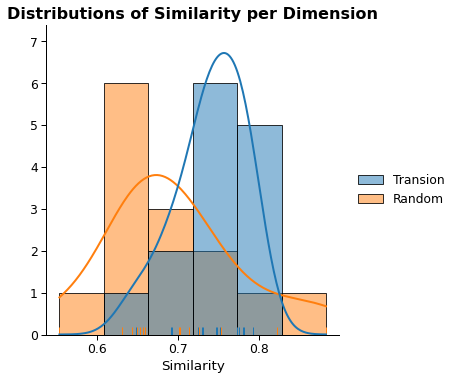

In [20]:
sns.set_context('paper', rc={"lines.linewidth": 2}, font_scale=1.4)
ax = sns.displot(pos_df, kde=True, rug=True)
ax.set(xlabel='Similarity', ylabel=' ')
#x.set(xlim=(0, 1.0))
plt.title('Distributions of Similarity per Dimension', weight='bold').set_fontsize('16')

**Start comparison of larger chunks**

In [41]:
# Save the chunked data as *.tsv files
for chunk in range(1, 78):
    for sub in sub_train_list:
        file_name = chunk_dir + f'/chunk-{chunk}_sub-{sub}.tsv'
        chunk_scene = chunk_train_data[(chunk_train_data['subject'] == int(sub)) & 
                         (chunk_train_data['chunk'] == chunk) &
                         (chunk_train_data['run'] == 1)].drop(columns=['subject', 'run', 'chunk'])
        
        chunk_scene.to_csv(file_name, index=False, sep ='\t')

In [50]:
chunk_train_sim = []

simi_dimensions = ['Shape', 'Direction', 'Length', 'Position', 'Duration']
chunk_index = 75

for sub_a in sub_train_list:
    a=mmg.remodnav_reader(chunk_dir + f'/chunk-{chunk_index}_sub-{sub_a}.tsv', screensize=screen_size)
    
    for sub_b in sub_train_list:
        b=mmg.remodnav_reader(chunk_dir + f'/chunk-{chunk_index}_sub-{sub_b}.tsv', screensize=screen_size)
        chunk_train_sim.append(mmg.docomparison(a, b, screensize=screen_size)[4])

<AxesSubplot:title={'center':'Pairwise Similarity of Chunk-75 for Dimension: Duration'}>

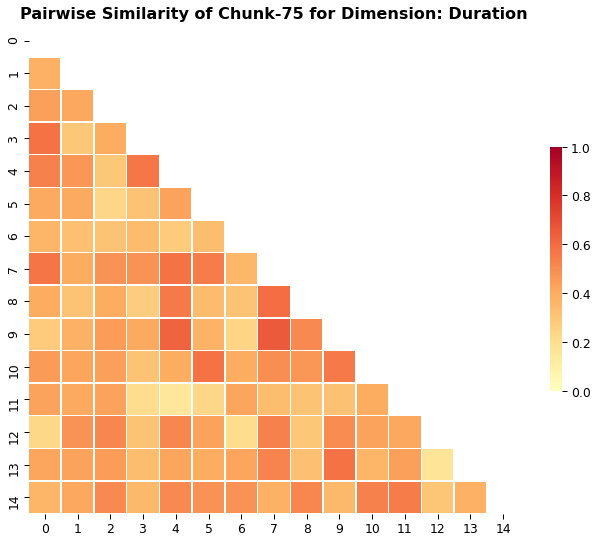

In [52]:
pos_sim = np.reshape(chunk_train_sim, (len(sub_train_list), len(sub_train_list)))
mask = np.triu(np.ones_like(pos_sim, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
plt.title(f'Pairwise Similarity of Chunk-{chunk_index} for Dimension: {simi_dimensions[4]}', weight='bold').set_fontsize('16')
sns.heatmap(pos_sim, mask=mask, center=0, cmap=plt.cm.get_cmap('RdYlBu_r'), vmin=0, vmax=1,
            linewidths=.5, cbar_kws={"shrink": .5})